# Model Evaluation

This notebook demonstrates the model evaluation pipeline: loading raw signals, applying STFT transformation, running inference through the ResNet autoencoder, and reconstructing the signal via inverse STFT.

The full data is loaded from:
- Radar: `RadarData/ProcessedRadarData/20240408_bin16_30/output/RX1_processed.txt` (column 8)
- ECG: `PSGData/20240408ecgdata.txt` (column 1)

Both signals are resampled to 128 Hz and filtered with bandpass filters (radar: 0.4-5 Hz, ECG: 0.3-30 Hz).

**You can select your desired data segment by specifying start_idx and duration in the data selection cell.**


## 1. Import packages


In [68]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.ndimage import zoom

# Add src to path
sys.path.insert(0, str(Path.cwd() / "src"))

from resnet_autoencoder import ResNetAutoencoder
from dataset import STFTDataset, STFTConfig
from signal_utils import inverse_stft, zscore, taper_edges_residual
from config_utils import load_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. Load configuration and model


In [69]:
# Load configuration
config_path = Path("configs/config.json")
cfg = load_config(config_path)

# Load pretrained model
model_path = Path("models/model_2024_08_23__162411.pth")
model = ResNetAutoencoder(
    encoded_space_dim=cfg["model"]["resnet_autoencoder"]["encoded_space_dim"],
    output_channels=cfg["model"]["resnet_autoencoder"]["output_channels"],
    dropout=cfg["model"]["resnet_autoencoder"]["dropout"],
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from: {model_path}")


Loaded model from: models/model_2024_08_23__162411.pth


## 3. Load full preprocessed signal data

The full data has been preprocessed:
- Resampled to 128 Hz
- Bandpass filtered (radar: 0.4-5 Hz, ECG: 0.3-30 Hz)

You can visualize the full data and select your desired segment.


In [70]:
# Load all radar columns and ECG signal (resampled but not filtered yet)
radar_all_path = Path("eval_data/radar_all_columns.npz")
ecg_full_path = Path("eval_data/ecg_full.npy")

radar_all = np.load(radar_all_path)
ecg_full = np.load(ecg_full_path)

fs = cfg['data']['fs_target']
n_columns = len([k for k in radar_all.keys() if k.startswith('col_')])
print(f"Radar file has {n_columns} columns (0-{n_columns-1})")
print(f"ECG full data: {len(ecg_full)} samples ({len(ecg_full)/fs:.2f} seconds @ {fs}Hz)")

# Show available columns
print(f"\nAvailable radar columns: 0 to {n_columns-1}")
for i in range(n_columns):
    col_data = radar_all[f'col_{i}']
    print(f"  Column {i}: {len(col_data)} samples, mean={col_data.mean():.4f}, std={col_data.std():.4f}")


Radar file has 16 columns (0-15)
ECG full data: 3554944 samples (27773.00 seconds @ 128Hz)

Available radar columns: 0 to 15
  Column 0: 4543482 samples, mean=14908.2822, std=8607.3075
  Column 1: 4543482 samples, mean=-7.9675, std=44.7998
  Column 2: 4543482 samples, mean=-5.9933, std=51.1637
  Column 3: 4543482 samples, mean=-5.8814, std=54.6948
  Column 4: 4543482 samples, mean=-9.5688, std=54.2253
  Column 5: 4543482 samples, mean=-8.3535, std=41.0307
  Column 6: 4543482 samples, mean=-5.1994, std=38.1524
  Column 7: 4543482 samples, mean=-7.7798, std=51.6299
  Column 8: 4543482 samples, mean=-7.6150, std=62.4104
  Column 9: 4543482 samples, mean=-10.3956, std=58.6805
  Column 10: 4543482 samples, mean=-8.2353, std=53.2872
  Column 11: 4543482 samples, mean=-8.4918, std=49.8393
  Column 12: 4543482 samples, mean=-14.4796, std=58.4918
  Column 13: 4543482 samples, mean=-14.2498, std=57.6645
  Column 14: 4543482 samples, mean=-13.5301, std=61.8910
  Column 15: 4543482 samples, mean=-

## 4. Select radar column and apply filtering

**Modify the parameter below to select your desired radar column (0-15):**


Selected column: 8
Radar filtered: 4543482 samples, mean=-0.0000, std=1.7589
ECG filtered: 3554944 samples, mean=-0.0000, std=0.3397


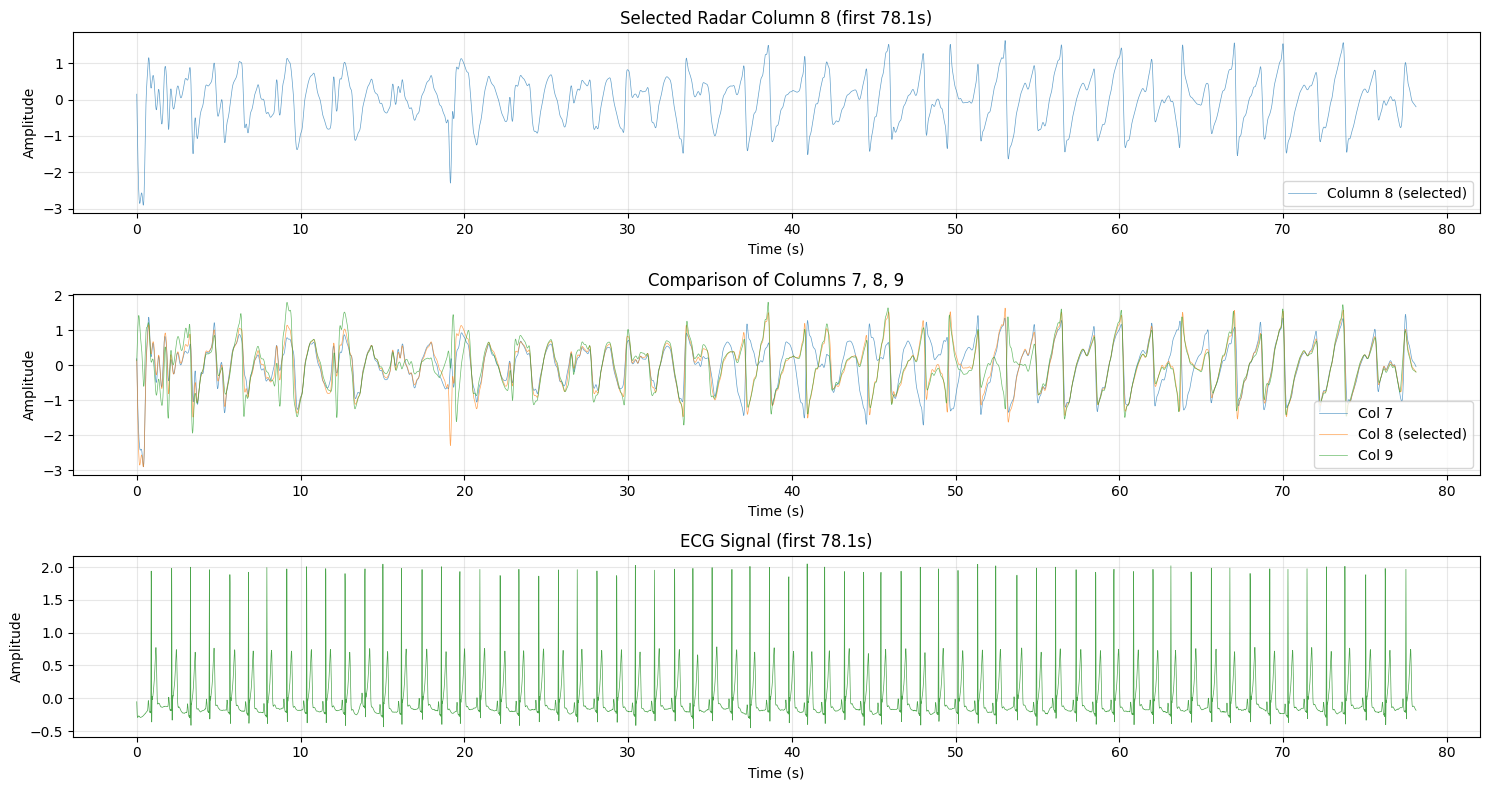

In [71]:
# ===== USER: Select radar column (0-15) =====
selected_column = 8  # Change this to select different column

# Extract selected column
radar_raw = radar_all[f'col_{selected_column}']

# Apply bandpass filter (0.4-5 Hz for radar)
from scipy.signal import butter, filtfilt
def bandpass_filter(sig, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, sig)

radar_filtered = bandpass_filter(radar_raw, fs, 0.4, 5.0, order=4)
ecg_filtered = bandpass_filter(ecg_full, fs, 0.3, 30.0, order=4)

print(f"Selected column: {selected_column}")
print(f"Radar filtered: {len(radar_filtered)} samples, mean={radar_filtered.mean():.4f}, std={radar_filtered.std():.4f}")
print(f"ECG filtered: {len(ecg_filtered)} samples, mean={ecg_filtered.mean():.4f}, std={ecg_filtered.std():.4f}")

# Visualize all columns for comparison (first 10k samples)
display_samples = min(10000, len(radar_filtered))
time_display = np.arange(display_samples) / fs

plt.figure(figsize=(15, 8))
# Show selected column
plt.subplot(3, 1, 1)
plt.plot(time_display, radar_filtered[:display_samples], alpha=0.7, linewidth=0.5, label=f'Column {selected_column} (selected)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Selected Radar Column {selected_column} (first {display_samples/fs:.1f}s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Show a few other columns for comparison
plt.subplot(3, 1, 2)
for col_idx in [7, 8, 9]:
    if col_idx < n_columns:
        col_data = radar_all[f'col_{col_idx}']
        col_filtered = bandpass_filter(col_data[:len(radar_filtered)], fs, 0.4, 5.0, order=4)
        label = f'Col {col_idx}' + (' (selected)' if col_idx == selected_column else '')
        plt.plot(time_display, col_filtered[:display_samples], alpha=0.7, linewidth=0.5, label=label)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Comparison of Columns 7, 8, 9")
plt.legend()
plt.grid(True, alpha=0.3)

# Show ECG
plt.subplot(3, 1, 3)
plt.plot(time_display, ecg_filtered[:display_samples], alpha=0.7, linewidth=0.5, color='green')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"ECG Signal (first {display_samples/fs:.1f}s)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Select data segment

**Modify the parameters below to select your desired segment:**
- `start_idx`: Starting sample index (0-based)
- `duration_seconds`: Duration in seconds (e.g., 5 for 5 seconds)

The selected segment will be extracted and used for model evaluation.


Selected segment:
  Radar column: 8
  Start index: 100000
  End index: 100640
  Duration: 5.00 seconds (640 samples)
  Time range: 781.25s - 786.25s

Radar stats: mean=0.0127, std=0.1682, var=0.0283
ECG stats: mean=-0.0106, std=0.3445, var=0.1187


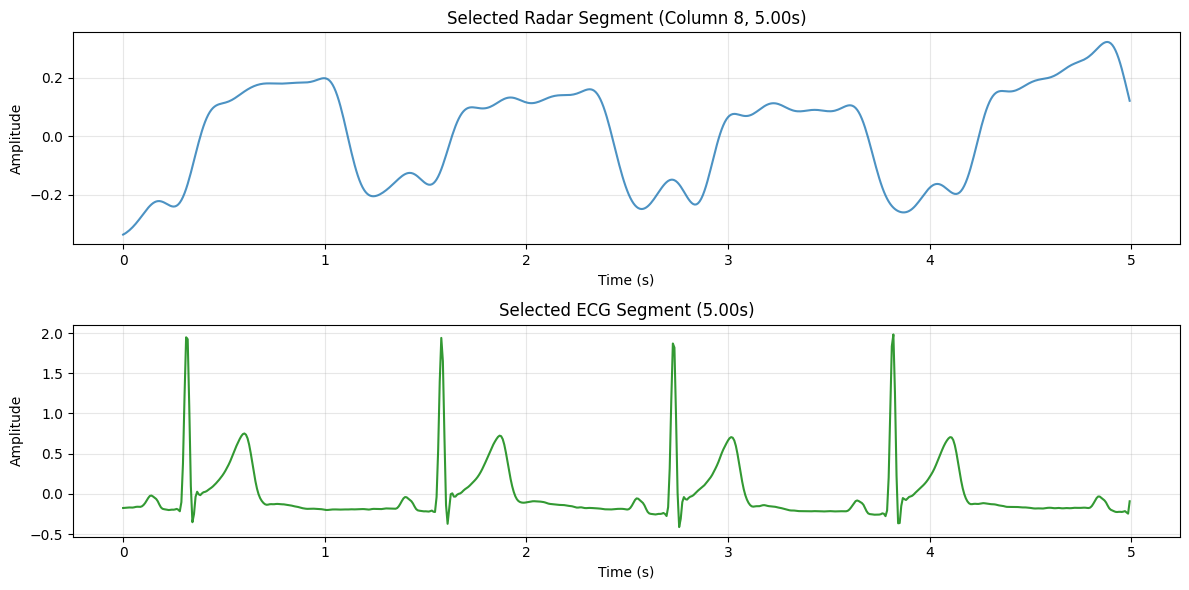

In [72]:
# ===== USER: Modify these parameters to select your data segment =====
start_idx = 100000  # Starting sample index (0-based)
duration_seconds = 5  # Duration in seconds

# ===== Extract selected segment =====
n_samples = int(duration_seconds * fs)
end_idx = start_idx + n_samples

# Ensure we don't exceed data length
end_idx = min(end_idx, len(radar_filtered), len(ecg_filtered))
n_samples = end_idx - start_idx

radar_signal = radar_filtered[start_idx:end_idx]
ecg_signal = ecg_filtered[start_idx:end_idx]

print(f"Selected segment:")
print(f"  Radar column: {selected_column}")
print(f"  Start index: {start_idx}")
print(f"  End index: {end_idx}")
print(f"  Duration: {n_samples/fs:.2f} seconds ({n_samples} samples)")
print(f"  Time range: {start_idx/fs:.2f}s - {end_idx/fs:.2f}s")
print(f"\nRadar stats: mean={radar_signal.mean():.4f}, std={radar_signal.std():.4f}, var={np.var(radar_signal):.4f}")
print(f"ECG stats: mean={ecg_signal.mean():.4f}, std={ecg_signal.std():.4f}, var={np.var(ecg_signal):.4f}")

# Visualize selected segment
time_seg = np.arange(n_samples) / fs

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_seg, radar_signal, alpha=0.8, linewidth=1.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Selected Radar Segment (Column {selected_column}, {n_samples/fs:.2f}s)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_seg, ecg_signal, alpha=0.8, linewidth=1.5, color='green')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Selected ECG Segment ({n_samples/fs:.2f}s)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. STFT transformation and model inference


In [73]:
# Normalize radar signal (z-score normalization)
radar_norm = (radar_signal - radar_signal.mean()) / (radar_signal.std() + 1e-6)

# Apply STFT transformation
stft_cfg = STFTConfig(
    fs=cfg["data"]["fs_target"],
    window_length=cfg["stft"]["window_length"],
    noverlap=cfg["stft"]["noverlap"],
    nfft=cfg["stft"]["nfft"],
    radar_bandpass=tuple(cfg["filters"]["radar_bandpass"]),
    ecg_bandpass=tuple(cfg["filters"]["ecg_bandpass"]),
    filter_order=cfg["filters"]["order"],
)

stft_map = STFTDataset.stft(radar_norm, stft_cfg)
orig_shape = stft_map.shape  # (time, freq*2)

# STFTDataset.stft already zooms to (64, 64), so we can use it directly
stft_tensor = torch.tensor(stft_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

print(f"STFT shape (already zoomed to 64x64): {stft_map.shape}")
print(f"Input tensor shape: {stft_tensor.shape}")

# Model inference
with torch.no_grad():
    recon_map = model(stft_tensor).squeeze(0).squeeze(0).cpu().numpy()

print(f"Reconstructed STFT shape: {recon_map.shape}")


STFT shape (already zoomed to 64x64): (64, 64)
Input tensor shape: torch.Size([1, 1, 64, 64])
Reconstructed STFT shape: (64, 64)


## 5. Inverse STFT reconstruction with edge tapering


In [74]:
# Reconstruct signal from STFT
recon_signal = inverse_stft(
    recon_map,
    cfg,
    cutoff=4.0,
    use_input_phase=False,
    phase_override=None,
    expected_samples=len(radar_signal),
)

# Apply edge tapering to reduce filtering edge artifacts
fs = cfg["data"]["fs_target"]
recon_signal = taper_edges_residual(recon_signal, fs, t_taper=0.2)

print(f"Reconstructed signal length: {len(recon_signal)} samples")
print(f"Original signal length: {len(radar_signal)} samples")


Reconstructed signal length: 640 samples
Original signal length: 640 samples


## 6. Visualization


Figure saved to: outputs/model_eval_comparison.png


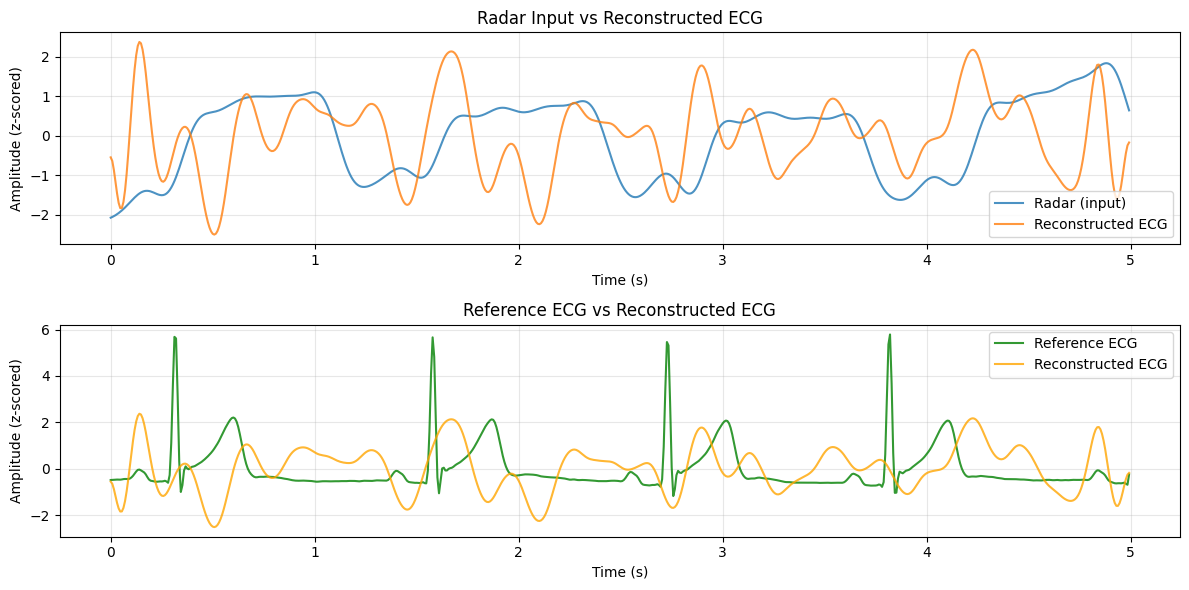

In [75]:
# Create time axis
time_axis = np.arange(len(radar_signal)) / fs

# Ensure same length for plotting
min_len = min(len(radar_signal), len(recon_signal), len(ecg_signal))
time_plot = time_axis[:min_len]
radar_plot = radar_signal[:min_len]
recon_plot = recon_signal[:min_len]
ecg_plot = ecg_signal[:min_len]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_plot, zscore(radar_plot), label="Radar (input)", alpha=0.8, linewidth=1.5)
plt.plot(time_plot, zscore(recon_plot), label="Reconstructed ECG", alpha=0.8, linewidth=1.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z-scored)")
plt.title("Radar Input vs Reconstructed ECG")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_plot, zscore(ecg_plot), label="Reference ECG", alpha=0.8, linewidth=1.5, color='green')
plt.plot(time_plot, zscore(recon_plot), label="Reconstructed ECG", alpha=0.8, linewidth=1.5, color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z-scored)")
plt.title("Reference ECG vs Reconstructed ECG")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/model_eval_comparison.png", dpi=200, bbox_inches='tight')
print("Figure saved to: outputs/model_eval_comparison.png")
plt.show()


Pearson Correlation Coefficient (PCC): -0.0831


Overlay figure saved to: outputs/model_eval_overlay.png


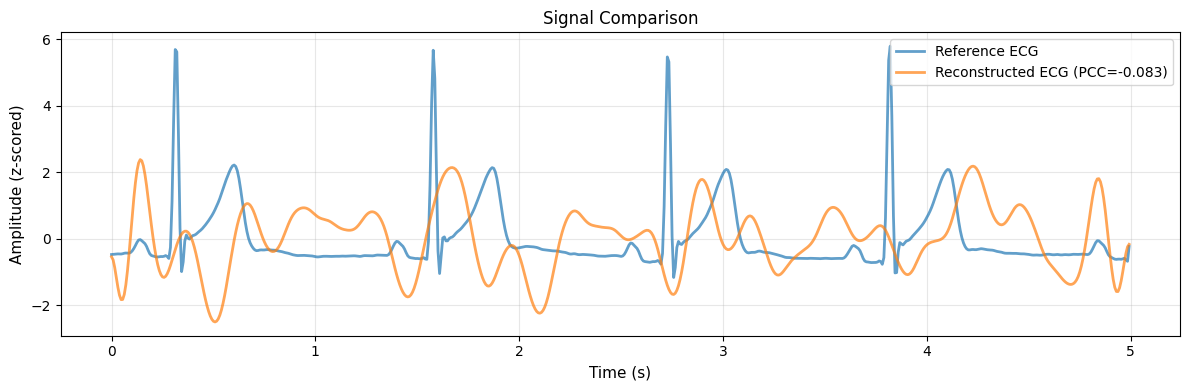

In [76]:
# Calculate correlation
from scipy.stats import pearsonr

pcc = pearsonr(zscore(ecg_plot), zscore(recon_plot))[0]
print(f"Pearson Correlation Coefficient (PCC): {pcc:.4f}")

# Plot overlay comparison
plt.figure(figsize=(12, 4))
plt.plot(time_plot, zscore(ecg_plot), label="Reference ECG", alpha=0.7, linewidth=2)
plt.plot(time_plot, zscore(recon_plot), label=f"Reconstructed ECG (PCC={pcc:.3f})", alpha=0.7, linewidth=2)
plt.xlabel("Time (s)", fontsize=11)
plt.ylabel("Amplitude (z-scored)", fontsize=11)
plt.title("Signal Comparison", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/model_eval_overlay.png", dpi=200, bbox_inches='tight')
print("Overlay figure saved to: outputs/model_eval_overlay.png")
plt.show()


# Model Evaluation

This notebook demonstrates the model evaluation pipeline: loading raw signals, applying STFT transformation, running inference through the ResNet autoencoder, and reconstructing the signal via inverse STFT.


## 1. Import packages


In [77]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.ndimage import zoom

# Add src to path
sys.path.insert(0, str(Path.cwd() / "src"))

from resnet_autoencoder import ResNetAutoencoder
from dataset import STFTDataset, STFTConfig
from signal_utils import inverse_stft, zscore
from config_utils import load_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. Load configuration and model


In [78]:
# Load configuration
config_path = Path("configs/config.json")
cfg = load_config(config_path)

# Load pretrained model
model_path = Path("models/model_2024_08_23__162411.pth")
model = ResNetAutoencoder(
    encoded_space_dim=cfg["model"]["resnet_autoencoder"]["encoded_space_dim"],
    output_channels=cfg["model"]["resnet_autoencoder"]["output_channels"],
    dropout=cfg["model"]["resnet_autoencoder"]["dropout"],
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Loaded model from: {model_path}")


Loaded model from: models/model_2024_08_23__162411.pth


## 3. Load raw signal data

The sample data is extracted from:
- Radar: `RadarData/ProcessedRadarData/20240408_bin16_30/output/RX1_processed.txt` (column 8)
- ECG: `PSGData/20240408ecgdata.txt` (column 1)

Both signals are resampled to 128 Hz and a 5-second segment is extracted.


In [79]:
# Load sample radar and ECG signals
radar_path = Path("eval_data/sample_radar.npy")
ecg_path = Path("eval_data/sample_ecg.npy")

radar_signal = np.load(radar_path)
ecg_signal = np.load(ecg_path)

print(f"Radar signal length: {len(radar_signal)} samples")
print(f"ECG signal length: {len(ecg_signal)} samples")
print(f"Sampling rate: {cfg['data']['fs_target']} Hz")
print(f"Duration: {len(radar_signal) / cfg['data']['fs_target']:.2f} seconds")
print(f"\nRadar stats: mean={radar_signal.mean():.4f}, std={radar_signal.std():.4f}")
print(f"ECG stats: mean={ecg_signal.mean():.4f}, std={ecg_signal.std():.4f}")


Radar signal length: 640 samples
ECG signal length: 640 samples
Sampling rate: 128 Hz
Duration: 5.00 seconds

Radar stats: mean=-3.7744, std=71.6895
ECG stats: mean=-0.0040, std=0.3632


## 4. STFT transformation and model inference


In [80]:
# Normalize radar signal
radar_norm = radar_signal - radar_signal.mean()
radar_norm = radar_norm / (radar_norm.std() + 1e-6)

# Apply STFT transformation
stft_cfg = STFTConfig(
    fs=cfg["data"]["fs_target"],
    window_length=cfg["stft"]["window_length"],
    noverlap=cfg["stft"]["noverlap"],
    nfft=cfg["stft"]["nfft"],
    radar_bandpass=tuple(cfg["filters"]["radar_bandpass"]),
    ecg_bandpass=tuple(cfg["filters"]["ecg_bandpass"]),
    filter_order=cfg["filters"]["order"],
)

stft_map = STFTDataset.stft(radar_norm, stft_cfg)
orig_shape = stft_map.shape  # (time, freq*2)

# STFTDataset.stft already zooms to (64, 64), so we can use it directly
stft_tensor = torch.tensor(stft_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

print(f"STFT shape (already zoomed to 64x64): {stft_map.shape}")
print(f"Input tensor shape: {stft_tensor.shape}")

# Model inference
with torch.no_grad():
    recon_map = model(stft_tensor).squeeze(0).squeeze(0).cpu().numpy()

print(f"Reconstructed STFT shape: {recon_map.shape}")


STFT shape (already zoomed to 64x64): (64, 64)
Input tensor shape: torch.Size([1, 1, 64, 64])
Reconstructed STFT shape: (64, 64)


## 5. Inverse STFT reconstruction


In [81]:
# Reconstruct signal from STFT
recon_signal = inverse_stft(
    recon_map,
    cfg,
    cutoff=4.0,
    use_input_phase=False,
    phase_override=None,
    expected_samples=len(radar_signal),
)

print(f"Reconstructed signal length: {len(recon_signal)} samples")
print(f"Original signal length: {len(radar_signal)} samples")


Reconstructed signal length: 640 samples
Original signal length: 640 samples


## 6. Visualization


Figure saved to: outputs/model_eval_comparison.png


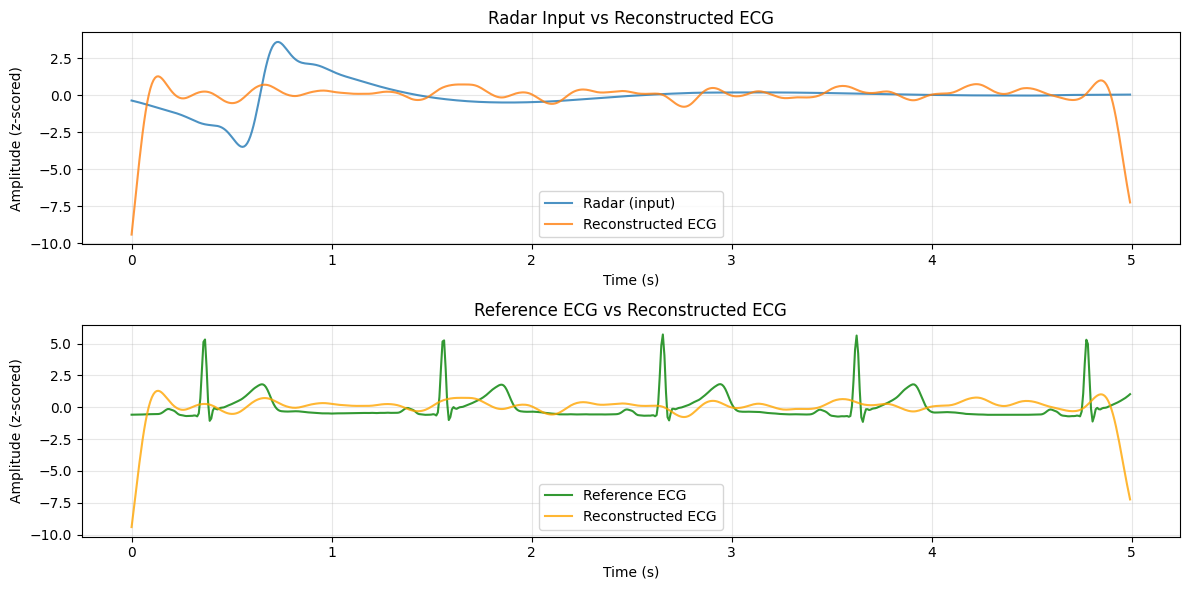

In [82]:
# Create time axis
fs = cfg["data"]["fs_target"]
time_axis = np.arange(len(radar_signal)) / fs

# Ensure same length for plotting
min_len = min(len(radar_signal), len(recon_signal), len(ecg_signal))
time_plot = time_axis[:min_len]
radar_plot = radar_signal[:min_len]
recon_plot = recon_signal[:min_len]
ecg_plot = ecg_signal[:min_len]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_plot, zscore(radar_plot), label="Radar (input)", alpha=0.8, linewidth=1.5)
plt.plot(time_plot, zscore(recon_plot), label="Reconstructed ECG", alpha=0.8, linewidth=1.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z-scored)")
plt.title("Radar Input vs Reconstructed ECG")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_plot, zscore(ecg_plot), label="Reference ECG", alpha=0.8, linewidth=1.5, color='green')
plt.plot(time_plot, zscore(recon_plot), label="Reconstructed ECG", alpha=0.8, linewidth=1.5, color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z-scored)")
plt.title("Reference ECG vs Reconstructed ECG")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/model_eval_comparison.png", dpi=200, bbox_inches='tight')
print("Figure saved to: outputs/model_eval_comparison.png")
plt.show()


Pearson Correlation Coefficient (PCC): 0.0060


Overlay figure saved to: outputs/model_eval_overlay.png


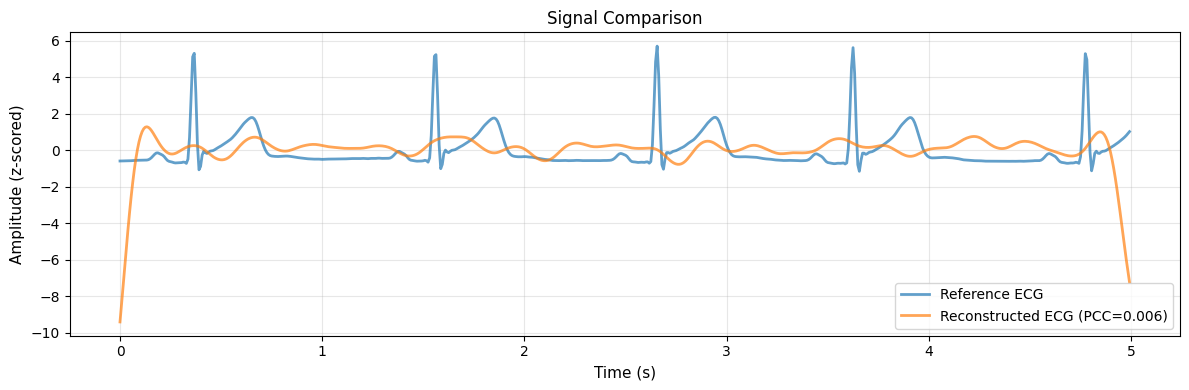

In [83]:
# Calculate correlation
from scipy.stats import pearsonr

pcc = pearsonr(zscore(ecg_plot), zscore(recon_plot))[0]
print(f"Pearson Correlation Coefficient (PCC): {pcc:.4f}")

# Plot overlay comparison
plt.figure(figsize=(12, 4))
plt.plot(time_plot, zscore(ecg_plot), label="Reference ECG", alpha=0.7, linewidth=2)
plt.plot(time_plot, zscore(recon_plot), label=f"Reconstructed ECG (PCC={pcc:.3f})", alpha=0.7, linewidth=2)
plt.xlabel("Time (s)", fontsize=11)
plt.ylabel("Amplitude (z-scored)", fontsize=11)
plt.title("Signal Comparison", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/model_eval_overlay.png", dpi=200, bbox_inches='tight')
print("Overlay figure saved to: outputs/model_eval_overlay.png")
plt.show()
